# Pylops-distributed - Marchenko redatuming without fftshift

### Author: M.Ravasi

This notebook extends the standard *Marchenko* algorithm in PyLops to distibuted computing with dask.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from dask.distributed import performance_report

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed import LinearOperator
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
n_workers = 4
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1,
                                               n_workers=n_workers)[0]
client

Client Scheduler: inproc://10.0.0.6/30368/1 Dashboard: http://10.0.0.6:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
#n_workers = 4
#client = pylops_distributed.utils.backend.dask(hardware='ssh', client='be-linrgsn014:8786')
#client

## Inputs

Input parameters 

In [4]:
inputfile = '../data/marchenko/input.npz'
zarrfile = '../data/marchenko/input.zarr/'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [5]:
inputdata = np.load(inputfile)

Read and visualize geometry

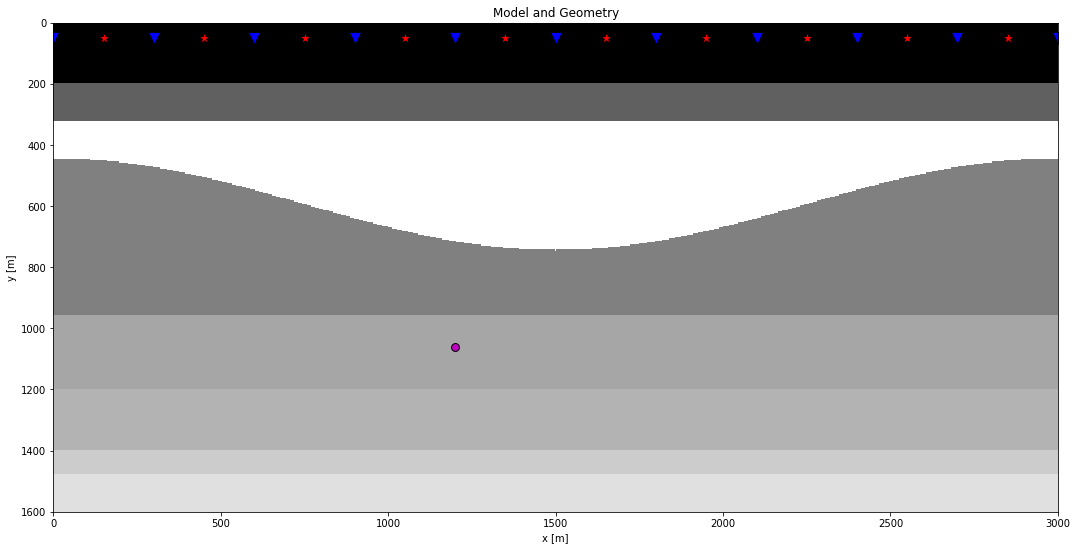

In [6]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [7]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [8]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
wav = inputdata['wav']
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

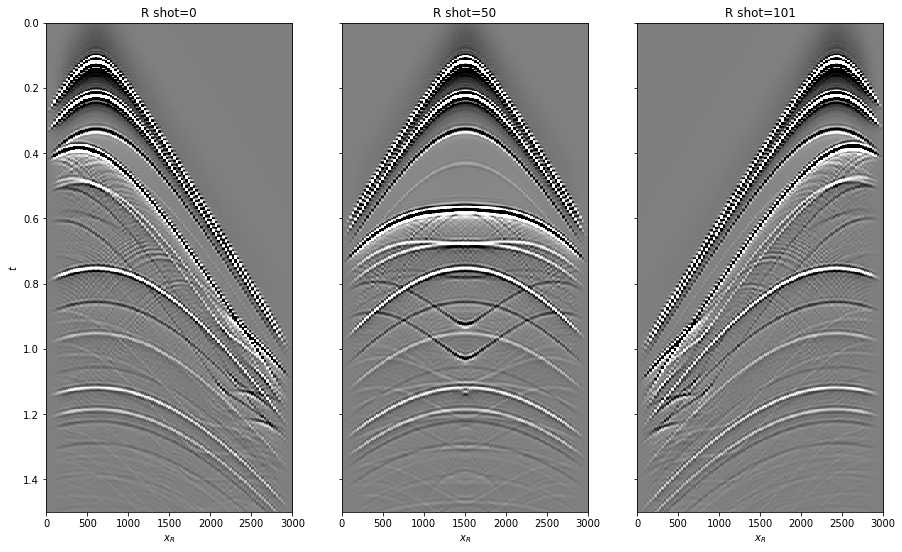

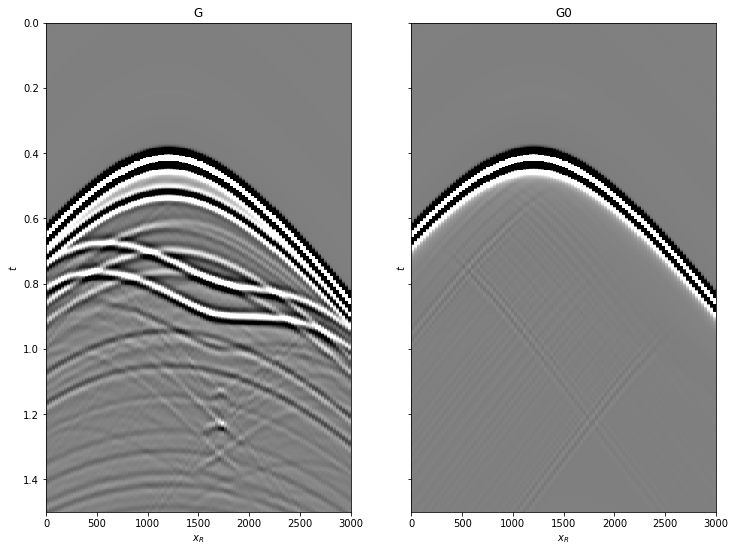

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

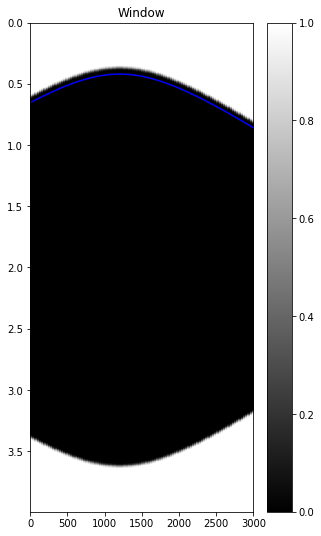

In [10]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((w[:, 1:], np.fliplr(w)))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], 2*t[-1], 0))
ax.plot(r[0], directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

Create analytical direct wave

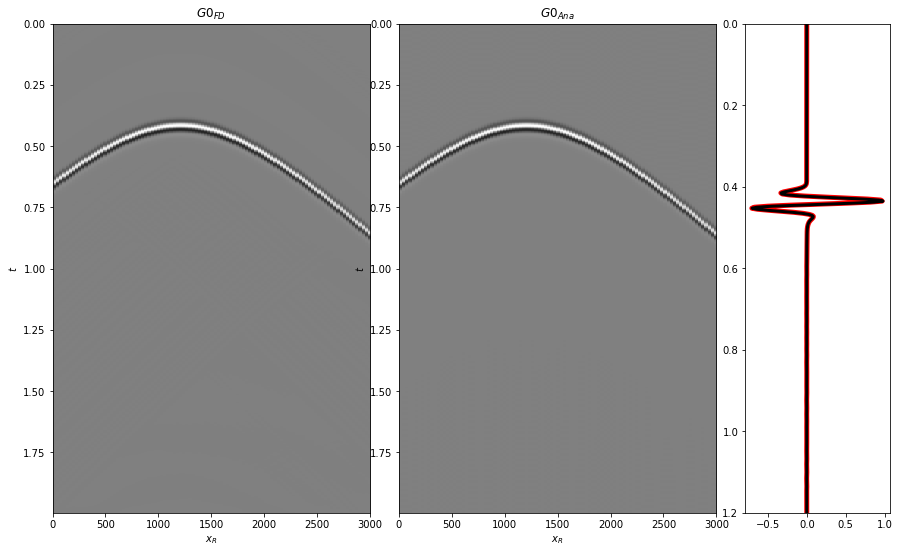

In [11]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

For now we will use the direct wave obtained via finite-difference, but we will show later that Marchenko redatuming can converge to the correct solution also when using an analytical direct wave.

In [12]:
w = w.astype(np.float32)
G0sub = G0sub.astype(np.float32)

## Inversion

In [13]:
# Add negative time to operators
Rtwosided = np.concatenate((R, np.zeros((nr, ns, nt-1))), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]
Rtwosided_fft = Rtwosided_fft.astype(np.complex64)

Convert ``Rtwosided_fft`` into dask, distributed over frequencies. In practice this will be done in pre-processing and here we will read it from Zarr file

In [14]:
dRtwosided_fft = da.from_array(Rtwosided_fft * dr * dt * np.sqrt(2*nt-1), 
                               chunks=(nfmax // n_workers, nr, ns))
dRtwosided_fft

dask.array<array, shape=(500, 101, 101), dtype=complex64, chunksize=(125, 101, 101), chunktype=numpy.ndarray>

### Distributed

Create distributed Marchenko operator

In [15]:
# Operators
dRop = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=False, 
            prescaled=True, todask=(True, True))
dR1op = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, 
             prescaled=True, twosided=False, conj=True, todask=(True, True))

# Input focusing function
dfd_plus =  np.concatenate((np.zeros((nt-1, nr), dtype=np.float32), np.fliplr(G0sub.T).T))
dfd_plus = da.from_array(dfd_plus)

In [16]:
dWop = dDiagonal(da.from_array(w.T.ravel()), dtype=np.float32)
dIop = dIdentity(nr*(2*nt-1), dtype=np.float32)

#dMop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dWop*dRop]),
#                                 pylops_distributed.HStack([-1*dWop*dRollop*dR1op, dIop])])*pylops_distributed.BlockDiag([dWop, dWop])
#dGop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dRop]),
#                                 pylops_distributed.HStack([-1*dRollop*dR1op, dIop])])
dMop = pylops_distributed.Block([[dIop, -1 * dWop * dRop],
                     [-1 * dWop * dR1op, dIop]]) * pylops_distributed.BlockDiag([dWop, dWop])
dGop = pylops_distributed.Block([[dIop, -1 * dRop],
             [-1 * dR1op, dIop]])
    
ddottest(dGop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), chunks=(2*nr*(2*nt-1), 2*nr*(2*nt-1)), verb=True)
ddottest(dMop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), chunks=(2*nr*(2*nt-1), 2*nr*(2*nt-1)), verb=True);

Dot test passed, v^T(Opu)=79496.101833 - u^T(Op^Tv)=79496.101831
Dot test passed, v^T(Opu)=20365.288057 - u^T(Op^Tv)=20365.288053


Run standard redatuming as benchmark

In [17]:
dp0_minus = dRop * dfd_plus.ravel()
dp0_minus = dp0_minus.reshape((2*nt-1), nr).T

In [18]:
dp0_minus.persist()

dask.array<transpose, shape=(101, 1599), dtype=float32, chunksize=(101, 1599), chunktype=numpy.ndarray>

Create data

In [19]:
dd = dWop*dRop*dfd_plus.ravel()
dd = da.concatenate((dd.reshape(2*nt-1, nr), da.zeros((2*nt-1, nr), dtype=np.float32)))

In [20]:
dd

dask.array<concatenate, shape=(3198, 101), dtype=float32, chunksize=(1599, 101), chunktype=numpy.ndarray>

Adjoint and inverse focusing functions

In [21]:
df1_adj = dMop.H * dd.ravel()
df1_inv = dcgls(dMop, dd.ravel(), niter=10, compute=True)[0]
#df1_inv = dcg(dMop.H * dMop, dMop.H * dd.ravel(), niter=10, client=client)

df1_adj = df1_adj.reshape(2*(2*nt-1), nr)
df1_inv = df1_inv.reshape(2*(2*nt-1), nr)

Add initial guess to estimated focusing functions

In [22]:
df1_adj_tot = df1_adj + da.concatenate((da.zeros((2*nt-1, nr), dtype=np.float32),
                                       dfd_plus))

df1_inv_tot = df1_inv + da.concatenate((da.zeros((2*nt-1, nr), dtype=np.float32),
                                        dfd_plus))

In [23]:
df1_inv_tot

dask.array<add, shape=(3198, 101), dtype=float32, chunksize=(1599, 101), chunktype=numpy.ndarray>

Estimate Green's functions

In [24]:
dg_adj = dGop * df1_adj_tot.ravel()
dg_inv = dGop * df1_inv_tot.ravel()

dg_adj = dg_adj.reshape(2*(2*nt-1), nr)
dg_inv = dg_inv.reshape(2*(2*nt-1), nr)

In [25]:
dd, dp0_minus, df1_adj_tot, df1_inv_tot, dg_adj, dg_inv = \
    da.compute(dd, dp0_minus, df1_adj_tot, df1_inv_tot, dg_adj, dg_inv)

Extract up and down focusing and Green's functions from model vectors

In [26]:
df1_adj_minus, df1_adj_plus = df1_adj_tot[:(2*nt-1)].T, df1_adj_tot[(2*nt-1):].T
df1_inv_minus, df1_inv_plus = df1_inv_tot[:(2*nt-1)].T, df1_inv_tot[(2*nt-1):].T

dg_adj_minus, dg_adj_plus =  -dg_adj[:(2*nt-1)].T, np.fliplr(dg_adj[(2*nt-1):].T)
dg_inv_minus, dg_inv_plus =  -dg_inv[:(2*nt-1)].T, np.fliplr(dg_inv[(2*nt-1):].T)

dg_inv_tot = dg_inv_minus + dg_inv_plus

Visualization

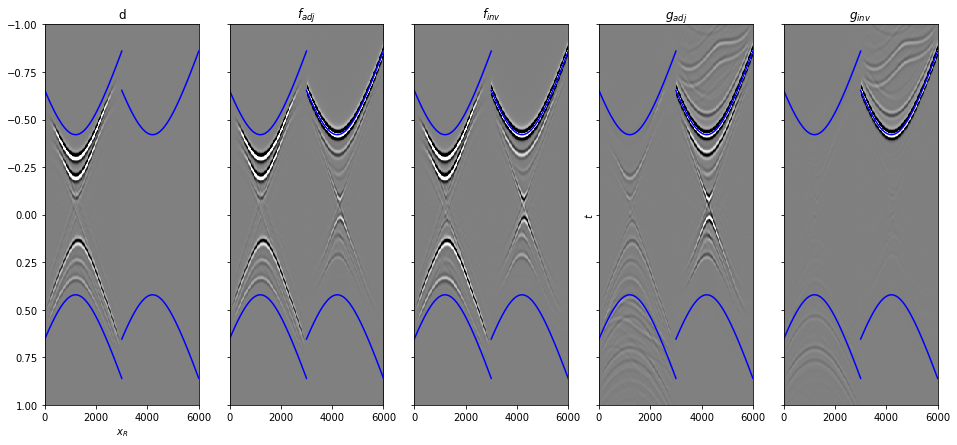

In [27]:
# Need to recreate combined data as new implementation stacks over time instead of space
dd = np.concatenate((dd[:(2*nt-1)], dd[(2*nt-1):]), axis=1).T
df1_adj_tot = np.concatenate((df1_adj_tot[:(2*nt-1)], df1_adj_tot[(2*nt-1):]), axis=1).T
df1_inv_tot = np.concatenate((df1_inv_tot[:(2*nt-1)], df1_inv_tot[(2*nt-1):]), axis=1).T
dg_adj = np.concatenate((dg_adj[:(2*nt-1)], dg_adj[(2*nt-1):]), axis=1).T
dg_inv = np.concatenate((dg_inv[:(2*nt-1)], dg_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(np.fft.ifftshift(dd, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].plot(r[0]+r[0,-1], directVS,'b'),axs[0].plot(r[0]+r[0,-1], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(np.fft.ifftshift(df1_adj_tot, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].plot(r[0]+r[0,-1], directVS,'b'),axs[1].plot(r[0]+r[0,-1], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.fft.ifftshift(df1_inv_tot, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].plot(r[0]+r[0,-1], directVS,'b'),axs[2].plot(r[0]+r[0,-1], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(np.fft.ifftshift(dg_adj, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].plot(r[0], directVS,'b'),axs[3].plot(r[0], -directVS,'b')
axs[3].plot(r[0]+r[0,-1], directVS,'b'),axs[3].plot(r[0]+r[0,-1], -directVS,'b')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(np.fft.ifftshift(dg_inv, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].plot(r[0], directVS,'b'),axs[4].plot(r[0], -directVS,'b')
axs[4].plot(r[0]+r[0,-1], directVS,'b'),axs[4].plot(r[0]+r[0,-1], -directVS,'b')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

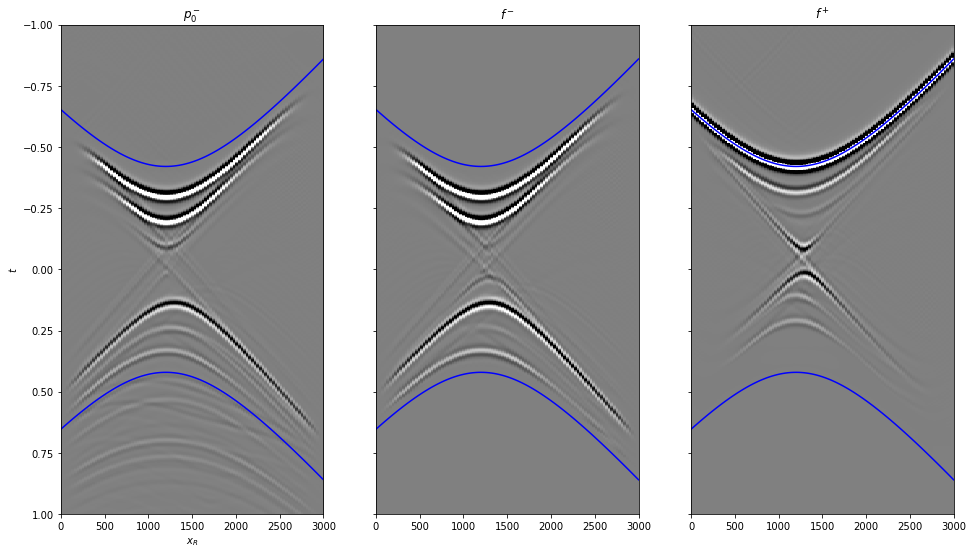

In [28]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.ifftshift(dp0_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(np.fft.ifftshift(df1_inv_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.fft.ifftshift(df1_inv_plus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

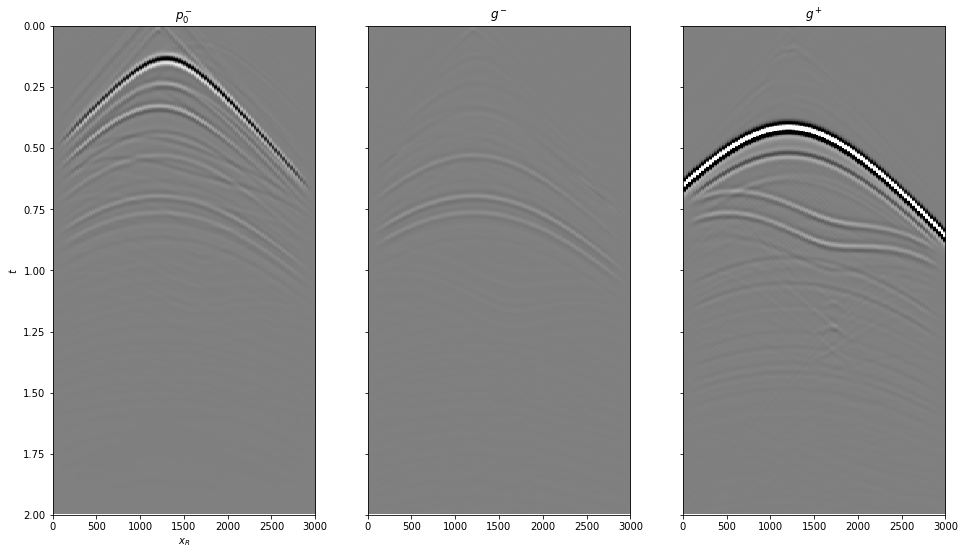

In [29]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.ifftshift(dp0_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(np.fft.ifftshift(dg_inv_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(np.fft.ifftshift(dg_inv_plus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

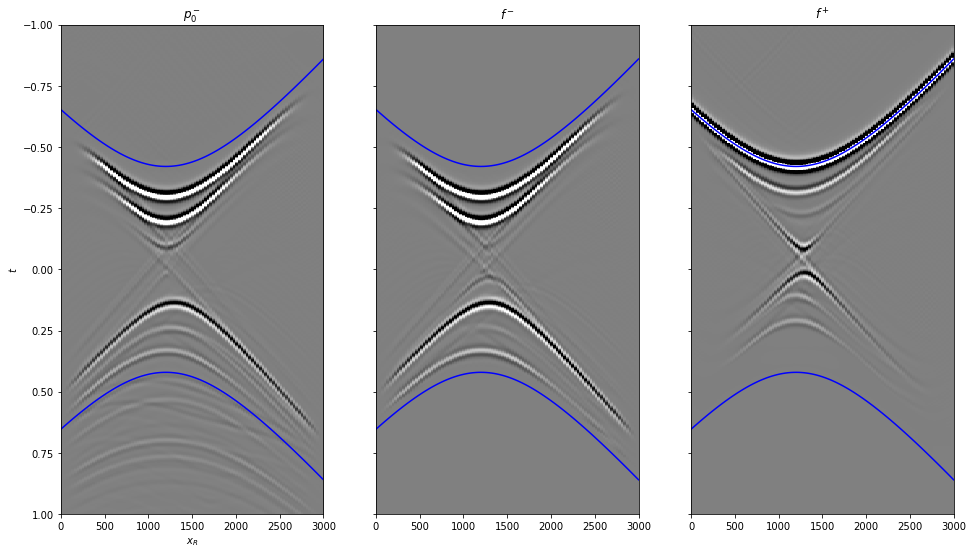

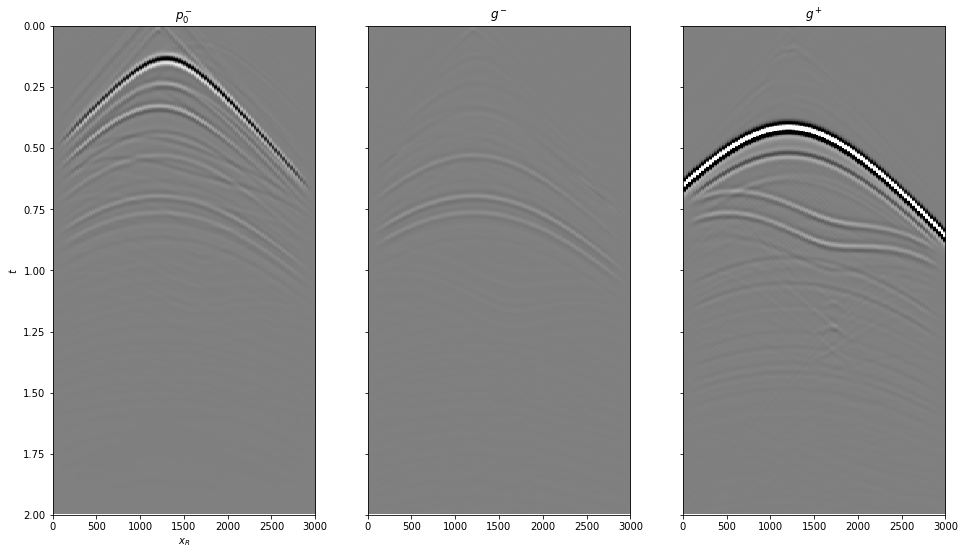

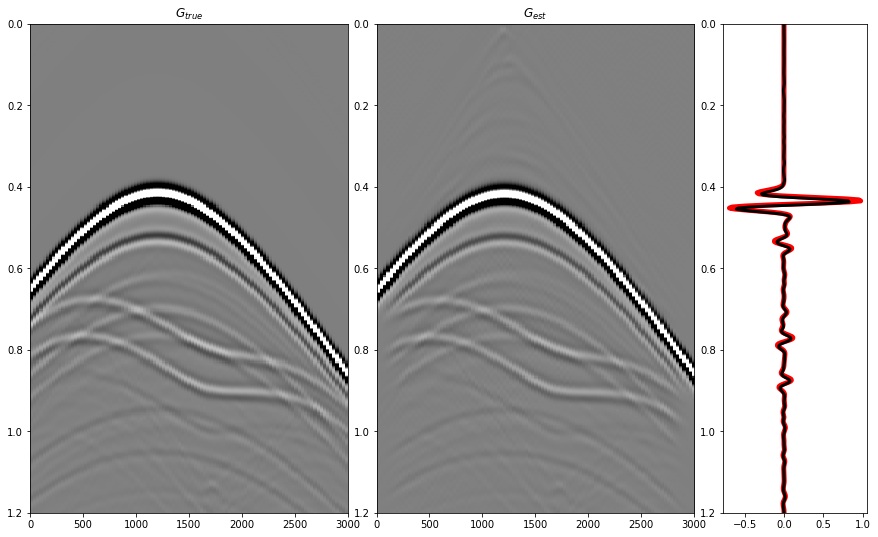

In [30]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.ifftshift(dp0_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(np.fft.ifftshift(df1_inv_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.fft.ifftshift(df1_inv_plus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(np.fft.ifftshift(dp0_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow(np.fft.ifftshift(dg_inv_minus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow(np.fft.ifftshift(dg_inv_plus, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(np.fft.ifftshift(dg_inv_tot, axes=1).T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(np.fft.ifftshift(dg_inv_tot, axes=1)[nr//2, nt-1:]/dg_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

In [31]:
with performance_report(filename="dask-report-mdc.html"):
        (dRop * dfd_plus.ravel()).compute()

In [32]:
client.close()